# PyTorch

In [2]:
import torch

In [3]:
from torch import nn

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.2MB/s]


In [6]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


#Creating Models

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
#Define model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


#Optimising model parameters


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [11]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.282813  [   32/60000]
loss: 2.281031  [ 3232/60000]
loss: 2.254449  [ 6432/60000]
loss: 2.251040  [ 9632/60000]
loss: 2.233239  [12832/60000]
loss: 2.231071  [16032/60000]
loss: 2.189500  [19232/60000]
loss: 2.171431  [22432/60000]
loss: 2.167997  [25632/60000]
loss: 2.111499  [28832/60000]
loss: 2.064140  [32032/60000]
loss: 2.033029  [35232/60000]
loss: 2.130269  [38432/60000]
loss: 2.039198  [41632/60000]
loss: 1.976361  [44832/60000]
loss: 1.967541  [48032/60000]
loss: 2.037031  [51232/60000]
loss: 1.931521  [54432/60000]
loss: 1.843266  [57632/60000]
Test Error: 
 Accuracy: 57.0%, Avg loss: 1.839236 

Epoch 2
-------------------------------
loss: 1.830835  [   32/60000]
loss: 1.853156  [ 3232/60000]
loss: 1.767166  [ 6432/60000]
loss: 1.718447  [ 9632/60000]
loss: 1.665517  [12832/60000]
loss: 1.731644  [16032/60000]
loss: 1.530828  [19232/60000]
loss: 1.526505  [22432/60000]
loss: 1.526646  [25632/60000]
loss: 1.494541  [28832/60000

#Saving Models

In [13]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


#Loading models

In [14]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))


<All keys matched successfully>

In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
model.eval()
x,y = test_data[0][0], test_data[0][1]
with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#Tensor

In [16]:
import numpy as np

In [17]:
data = [[1,2],[3,4]]
x_data = torch.tensor(data)

In [18]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [19]:
x_ones = torch.ones_like(x_data)
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8626, 0.9835],
        [0.8317, 0.6207]]) 



In [20]:
shape = (2,3, )
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.0228, 0.3780, 0.8852],
        [0.1426, 0.7472, 0.2895]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


# CUDA and GPUs

**GPU** stands for Graphics Processing Unit. While originally designed for rendering graphics, GPUs have evolved into powerful parallel processors capable of handling a wide range of computational tasks.

**CUDA** (Compute Unified Device Architecture) is a parallel computing platform and API developed by NVIDIA. It allows developers to use NVIDIA GPUs for general-purpose processing (GPGPU) beyond just graphics rendering.

**Why are they called Accelerators?**

GPUs are called accelerators because they can significantly speed up computations compared to traditional CPUs for tasks that can be parallelized. Their architecture, with thousands of smaller cores, is highly efficient at performing many simple operations simultaneously, which is common in tasks like:

* **Machine Learning and Deep Learning:** Training neural networks involves a massive number of matrix multiplications and other parallelizable operations.
* **Scientific Simulations:** Many scientific simulations involve complex calculations that can be broken down into independent parts.
* **Data Processing:** Large datasets can be processed much faster by distributing the work across multiple GPU cores.

By offloading these parallelizable tasks to the GPU, the CPU is freed up to handle other parts of the program, resulting in a significant overall performance increase.

In [21]:
if torch.accelerator.is_available():
  accelerator = torch.accelerator.current_accelerator()
  print(f"Using {accelerator.type}")
else:
  print("Using CPU")

Using cuda


In [24]:
tensor = torch.rand(3,4)
print(f"Device tensor is stored on: {tensor.device}")
print(f"Tensor: {tensor.shape}")
print(f"Tensor: {tensor.dtype}")

Device tensor is stored on: cpu
Tensor: torch.Size([3, 4])
Tensor: torch.float32


In [25]:
if torch.accelerator.is_available():
  tensor = tensor.to(torch.accelerator.current_accelerator())
  print("Device tensor is stored on:", tensor.device)

Device tensor is stored on: cuda:0


In [27]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [30]:
t1 = torch.cat((tensor, tensor, tensor), dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [32]:
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(tensor)
print(y3)

torch.matmul(tensor, tensor.T, out=y3)
print(y1)
print(y2)
print(y3)

z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)
print(z1)
print(z2)
print(z3)

tensor([[0.6492, 0.9012, 0.7038, 0.8392],
        [0.1111, 0.1089, 0.4811, 0.8669],
        [0.6007, 0.3967, 0.1431, 0.9670],
        [0.3500, 0.8840, 0.1011, 0.0156]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [33]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [34]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


#Bridge with numpy

In [35]:
n = np.ones(5)
t = torch.from_numpy(n)
print(f"t: {t}")
np.add(n, 1, out=n)
print(f"t: {t}")

t: tensor([1., 1., 1., 1., 1.], dtype=torch.float64)
t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


# Datasets & DataLoaders

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 274kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 4.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 17.3MB/s]


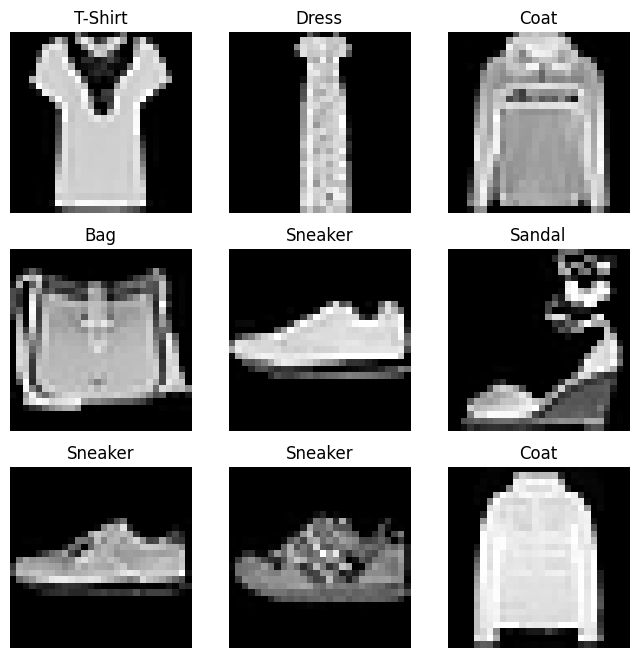

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols*rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
#creating custom dataset, needs to define __init__, __len__, and __getitem__
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)


  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = decode_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    sample = {"image": image, "label": label}

In [7]:
# training data with dataloaders

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


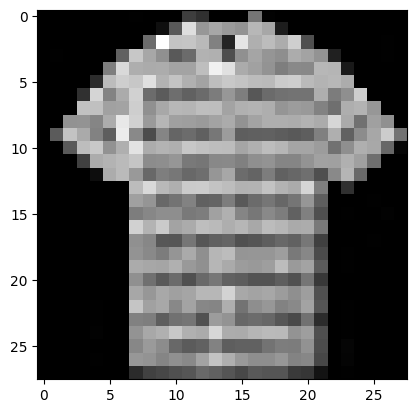

Label: 6


In [11]:
#iterate through dataloder
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#Transformers

In [12]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

In [13]:
ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

#Building NN

In [15]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [20]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [23]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10),
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [24]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [25]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_pobab = nn.Softmax(dim=1)(logits)
y_pred = pred_pobab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([9])


#Automatic Differentiation

In [26]:

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [28]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7ce5c87c54e0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7ce5c919e7d0>


In [29]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.0263, 0.2360, 0.0620],
        [0.0263, 0.2360, 0.0620],
        [0.0263, 0.2360, 0.0620],
        [0.0263, 0.2360, 0.0620],
        [0.0263, 0.2360, 0.0620]])
tensor([0.0263, 0.2360, 0.0620])


In [31]:
#disabling grad
z = torch.matmul(x, w) + b
print(z.requires_grad)

with torch.no_grad():
  z = torch.matmul(x, w) + b
print(z.requires_grad)

True
False


In [33]:
z = torch.matmul(x,w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


In [35]:
#optimising model params
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

In [36]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [37]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [39]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298360  [   64/60000]
loss: 2.296858  [ 6464/60000]
loss: 2.268834  [12864/60000]
loss: 2.268271  [19264/60000]
loss: 2.246887  [25664/60000]
loss: 2.211412  [32064/60000]
loss: 2.231688  [38464/60000]
loss: 2.185681  [44864/60000]
loss: 2.200842  [51264/60000]
loss: 2.165257  [57664/60000]
Test Error: 
 Accuracy: 35.3%, Avg loss: 2.161551 

Epoch 2
-------------------------------
loss: 2.163890  [   64/60000]
loss: 2.169891  [ 6464/60000]
loss: 2.104145  [12864/60000]
loss: 2.124216  [19264/60000]
loss: 2.076651  [25664/60000]
loss: 2.011813  [32064/60000]
loss: 2.049794  [38464/60000]
loss: 1.962413  [44864/60000]
loss: 1.983871  [51264/60000]
loss: 1.913585  [57664/60000]
Test Error: 
 Accuracy: 51.6%, Avg loss: 1.911025 

Epoch 3
-------------------------------
loss: 1.933333  [   64/60000]
loss: 1.922820  [ 6464/60000]
loss: 1.799210  [12864/60000]
loss: 1.837567  [19264/60000]
loss: 1.734182  [25664/60000]
loss: 1.683103  [32064/600

In [43]:
#save and load model
import torch
import torchvision.models as models

model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 86.9MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
torch.save(model, 'model.pth')
# model = torch.load('model.pth')